# 딥러닝 최적 모델 학습 (2)

손실함수의 목표 : 손실이 0이 되는 것 (=경사하강법의 목표)
일반 경사하강법 : 전체 데이터 대상 / 배치 전체를 기준으로 넣음 => 기울기 계산 -> 학습 속도 느림

확률적 경사하강법(SGD) :  랜덤성 부여. 매 반복마다 무작위로 한개(또는 작은 미니배치)의 샘플 데이터셋 추출해 가중치 계산 -> 학습 속도 빠름

일반 경사하강법 VS 확률적 경사하강법(SGD)
일반 경사하강법은 SGD 보다 안정성이 높다.

$ v \leftarrow \alpha v - \eta \frac{\partial L}{\partial w} $


In [2]:
# SGD 최적화 함수 업데이트
import numpy as np

# 새 가중치를 반환하는 함수(현재 가중치, 기울기, lr:선택)
def sgd_update(w, grad, lr=0.01):
    return w - lr * grad

# 가중치와 기울기
w = np.array([0.5, -0.3])
grad = np.array([0.2, -0.4])

# SGD 업데이트 적용
w_new = sgd_update(w, grad)
print("Updated weights:", w_new)

Updated weights: [ 0.498 -0.296]


## 모멘텀(Momentum)

## Momentum 경사하강법 요약

$$
\mathbf{v} \leftarrow \alpha \mathbf{v} - \eta \frac{\partial L}{\partial \mathbf{w}}
$$

- **$\mathbf{v}$** : 이전 이동 방향을 누적한 속도(관성)
- **$\alpha$** : 모멘텀 계수 (보통 0.9)
- **$\eta$** : 학습률
- **$\frac{\partial L}{\partial \mathbf{w}}$** : 손실 함수의 기울기

👉 과거 이동 방향(관성)과 현재 기울기를 결합해  
더 빠르고 안정적으로 최적점으로 이동

---

### 가중치 업데이트
$$
\mathbf{w} \leftarrow \mathbf{w} + \mathbf{v}
$$

In [3]:
# momentum 업데이트 함수: 누적속도 V를 이용해 기울기 변동을 완화하고 더 안정적으로 가중치를 갱신
def momentum_update(w, v, grad, lr=0.01, momentum=0.9):
    v = momentum * v - lr * grad        # 이전 이동방향 유지 + 현재 기울기 반영
    w += v                              # 속도 만큼 가중치 업데이트
    return w, v

# 초기값 설정
w = np.array([0.5, -0.3])
v = np.array([0.0, 0.0])
grad = np.array([0.2, -0.4])

# 모멘텀 업데이트 적용
w_new, v_new = momentum_update(w, v, grad)
print("Updated weights:", w_new)
print("Updated velocity:", v_new)

Updated weights: [ 0.498 -0.296]
Updated velocity: [-0.002  0.004]


### 3. AdaGrad
- 희소한 특성(0)이 많은 경우 : 원핫 인코딩/임베딩 사용, 추천시스템 user/item ID => 파라미터가 학습이 잘되는 경향 있음.
- 학습률을 개별 파라미터마다 다르게 적용하는 기법 (자주 업뎃 특성 -> lr ⬇️, 희소한 특성 -> lr ⬆️)

- 기울기의 제곱합이 계속 누적되면서 학습률 급격히 감소해 학습 멈춤 가능성  (AdaGrad 단점 보완 모델 : RMSprop)
    - (RMSprop(0이되어 멈추는 문제 해결) -> Adam(=요즘 많이 쓰이는 기법))   
                            - Adam : RMSprop(보폭조절) + Momentum


 #### $$ w \leftarrow w - \frac{\eta}{\sqrt{h} + \epsilon} \frac{\partial L}{\partial w} $$
 - $\epsilon$ : 0으로 나누는 것 방지용 작은 수(수치 안정화)
 - 학습률 조절로 분모가 작아지면 학습률 ⬆️ 
 - 결론 : 기울기 크기에 따라 학습률 나눠줌으로 자주 업뎃되면 속도를 낮춰준다. 자주 업뎃 안되면 속도 높여주는 방법



  
- **$h$** : 누적 제곱 기울기
- **$w$** : 업데이트할 파라미터(가중치)
- **$\eta$** : 기본 학습률(전역 learning rate)
- **$\frac{\partial L}{\partial w}$** : 현재 기울기(gradient)
- **$\epsilon$** : 0으로 나누는 것을 방지하기 위한 작은 상수(수치 안정화)

In [4]:
# AdaGrad 업데이트 함수 : 누적 제곱 기울기(h)를 이용해 파라미터 별 학습 률을 자동으로 조절한다.
def adagrad_update(w, grad, h, lr=0.01, epsilon=1e-8):
    h += grad ** 2
    w -= (lr / (np.sqrt(h) + epsilon)) * grad
    return w, h

# 초기값 설정
w = np.array([0.5, -0.3])
h = np.array([0.0, 0.0])
grad = np.array([0.2, -0.4])

# AdaGrad 업데이트 적용
w_new, h_new = adagrad_update(w, grad, h)
print("Updated weights:", w_new)
print("Updated 누적 제곱 기울기:", h_new)

Updated weights: [ 0.49 -0.29]
Updated 누적 제곱 기울기: [0.04 0.16]


## RMSprop 기울기 제곱 평균(EMA) 갱신 요약

$$
h_t \leftarrow \beta h_{t-1} + (1 - \beta)\left(\frac{\partial L}{\partial w}\right)^2
$$

- **$h_t$** : $t$번째 스텝에서의 기울기 제곱 평균 (지수이동평균, EMA)
- **$h_{t-1}$** : 이전 스텝까지 누적된 기울기 제곱 평균
- **$\left(\frac{\partial L}{\partial w}\right)^2$** : 현재 스텝의 기울기 제곱 (기울기 크기 정보)
- **$\beta$** : 감쇠율(decay rate, 일반적으로 0.9)
  - $\beta$가 클수록 과거 기울기 정보를 더 많이 유지
  - $(1-\beta)$는 현재 기울기 제곱을 반영하는 비율

### 부가 설명
RMSprop은 기울기 제곱의 단순 누적 대신 지수이동평균을 사용하여  
과거의 큰 기울기 영향은 점차 줄이고, 최근 기울기 크기를 중심으로  
학습률을 조절한다.  
이를 통해 학습률이 지나치게 빠르게 감소하는 문제를 완화하고,  
비정상적인 진동이나 발산을 줄이는 데 목적이 있다.

------------------------------------------------------------

## RMSprop 가중치 업데이트 요약

$$
w \leftarrow w - \frac{\eta}{\sqrt{h_t} + \epsilon} \frac{\partial L}{\partial w}
$$

- **$w$** : 업데이트할 파라미터(가중치)
- **$\eta$** : 기본 학습률(전역 learning rate)
- **$\frac{\partial L}{\partial w}$** : 현재 기울기(gradient)
- **$h_t$** : 최근 기울기 제곱의 지수이동평균(EMA)
- **$\epsilon$** : 0으로 나누는 것을 방지하기 위한 작은 상수(수치 안정화)

### 부가 설명
RMSprop은 현재 기울기의 방향은 그대로 사용하면서,  
최근 기울기 크기의 평균인 $h_t$로 나누어 파라미터별 스텝 크기를 자동으로 조절한다.  
기울기가 자주 크게 변하는 방향에서는 학습률이 줄어들고,  
변화가 작은 방향에서는 상대적으로 큰 스텝을 유지하여  
학습의 안정성과 수렴 속도를 개선한다.

In [6]:
# RMSprop 업데이트 합수 : 지수이동평균(EMA) 으로 제곱기울기(h)를 누적해 AdaGrad의 학습률 급감 문제를 완화하여 W값을 갱신
def rmsprop_update(w, h, grad, lr=0.01, beta=0.9, epsilon=1e-8):
    h = beta * h + (1 - beta) * (grad ** 2)         # 지수이동평균 EMA
    w -= (lr / (np.sqrt(h) + epsilon)) * grad       # 스텝 크기 조정
    return w, h

## Adam 옵티마이저 업데이트 과정 요약

- **개요**  
  Adam 옵티마이저가 손실 함수  
  $$
  L(w) = w^2
  $$  
  에서 가중치 $w$를 반복적으로 업데이트하며 **최솟값 $w=0$** 방향으로 수렴하는 과정을 나타냄.

- **구성 요소**
  - **검은 곡선**: 손실 함수 $L(w)=w^2$ (포물선)
  - **x축**: 가중치 $w$
  - **y축**: 손실 $L(w)$
  - **빨간 점**: 각 학습 step에서 갱신된 가중치 $w$의 위치(업데이트 궤적)

- **부가 설명**
  Adam은 기울기의 **1차 모멘트(평균)**와 **2차 모멘트(제곱 평균)**를 동시에 고려해
  스텝 크기를 자동 조절한다.  
  이로 인해 초기에는 비교적 큰 스텝으로 빠르게 이동하고,
  최솟값 근처에서는 스텝이 줄어들며 안정적으로 $w=0$에 수렴한다.

---

## Adam 옵티마이저 – 1차 모멘트(기울기 EMA) 업데이트

Adam(Adaptive Moment Estimation)은 **Momentum과 RMSprop을 결합한 방법**으로,  
기울기의 **1차 모멘트(이동평균)**와 **2차 모멘트(제곱 이동평균)**를 함께 사용해
안정적이고 빠른 학습을 수행한다.

### 1차 모멘트 업데이트 식
$$
m \leftarrow \beta_1 m + (1 - \beta_1)\frac{\partial L}{\partial w}
$$

### 변수 설명
- **$m$** : 기울기의 지수이동평균(EMA), 모멘텀 역할  
  → 과거 기울기 방향을 누적해 현재 업데이트 방향을 안정화
- **$\frac{\partial L}{\partial w}$** : 현재 스텝의 기울기(gradient)
- **$\beta_1$** : 1차 모멘트의 감쇠율(decay rate, 일반적으로 0.9)
  - $\beta_1$가 클수록 과거 기울기 정보를 더 오래 유지
  - $(1-\beta_1)$는 현재 기울기를 반영하는 비율

### 부가 설명
1차 모멘트는 **기울기의 방향 정보**를 부드럽게 평균내어,
노이즈가 큰 경우에도 업데이트 방향이 급격히 변하지 않도록 한다.  
이로 인해 단순 경사하강법보다 진동이 줄고,  
Momentum과 유사한 효과로 수렴 속도와 안정성이 향상된다.

---


## Adam 옵티마이저 – 2차 모멘트(기울기 제곱 EMA) 업데이트

### 2차 모멘트 업데이트 식
$$
v \leftarrow \beta_2 v + (1 - \beta_2)\left(\frac{\partial L}{\partial w}\right)^2
$$

### 변수 설명
- **$v$** : 기울기 제곱의 지수이동평균(EMA)  
  → 최근 기울기의 **크기(scale)**를 추적하는 통계값
- **$\left(\frac{\partial L}{\partial w}\right)^2$** : 현재 기울기를 제곱한 값  
  → 부호(±)를 제거하고 크기 정보만 반영
- **$\beta_2$** : 2차 모멘트의 감쇠율(decay rate, 일반적으로 0.999)
  - $\beta_2$가 클수록 과거 정보의 비중이 커짐
  - 평균이 더 부드럽게 변하며 급격한 스케일 변화가 완화됨

### 부가 설명
2차 모멘트는 학습률의 **분모 역할**을 하여,
기울기가 자주 크게 변하는 파라미터에서는 스텝 크기를 줄이고  
변화가 작은 파라미터에서는 상대적으로 큰 스텝을 유지하게 한다.  
이를 통해 Adam은 학습의 안정성과 수렴 특성을 동시에 확보한다.

---

## Adam 옵티마이저 – 가중치 업데이트

### 가중치 업데이트 식
$$
w \leftarrow w - \frac{\eta}{\sqrt{v} + \epsilon} \, m
$$

### 변수 설명
- **$w$** : 업데이트할 가중치(파라미터)
- **$\eta$** : 기본 학습률(전역 learning rate)
- **$m$** : 1차 모멘트  
  → 기울기의 지수이동평균(EMA), 업데이트 **방향**과 관성을 결정
- **$v$** : 2차 모멘트  
  → 기울기 제곱의 지수이동평균(EMA), 업데이트 **스케일(크기)**을 조절
- **$\epsilon$** : 0으로 나누는 문제를 방지하기 위한 작은 상수(수치 안정화)

### 부가 설명
Adam은 1차 모멘트 $m$으로 이동 방향을 결정하고,  
2차 모멘트 $v$로 스텝 크기를 조절하여 파라미터를 갱신한다.  
이 구조를 통해 노이즈가 큰 상황에서도 안정적인 업데이트가 가능하며,  
Momentum과 RMSprop의 장점을 동시에 활용한다.

In [ ]:
# Adam 업데이트 함수 : 1차 모멘트(m)와 2차 모멘트(v)의 지수 이동 평균 + 편향 보정으로 안정적으로 가중치(W) 갱신
def adam_update(w, m, v, grad, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = beta1 * m + (1 - beta1) * grad                  # 기울기 EMA : 1차 모멘트
    v = beta2 * v + (1 - beta2) * (grad ** 2)           # 제곱 기울기 EMA : 2차 모멘트
    m_hat = m / (1 - beta1 ** t)                        # 편향 보정 (초반 M값이 0쪽으로 치우침 보정)
    v_hat = v / (1 - beta2 ** t)                        # 편향 보정 (초반 V값이 0쪽으로 치우침 보정)
    w -= (lr / (np.sqrt(v_hat) + epsilon)) * m_hat      # 가중치 업데이트
    return w, m, v                                      

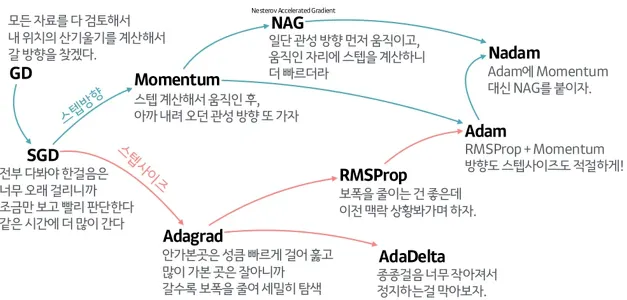

## 옵티마이저 계열 정리

| 옵티마이저 | 핵심 아이디어 | 해결하려는 문제 | 
|---|---|---| 
| **GD** | 전체 데이터로 기울기 계산 | 계산 비용 큼, 느림 | 
| **SGD** | 미니배치로 기울기 계산 | 진동 큼, 불안정 | 
| **Momentum** | 이전 방향(관성) 누적 | SGD의 진동 문제 | 
| **NAG** | 미리 이동 후 기울기 계산 | 과도한 관성 이동 |
| **Adagrad** | 파라미터별 학습률 적용 | 학습률이 너무 빨리 감소 |
| **RMSprop** | 기울기 제곱 EMA 사용 | Adagrad의 학습 정지 문제 | 
| **Adadelta** | 학습률 의존도 감소 | RMSprop 개선 | 
| **Adam** | Momentum + RMSprop 결합 | 방향 + 스케일 동시 고려 | 
| **Nadam** | Adam + NAG | 방향 예측 정확도 향상 |

